In [1]:
import sys
sys.path.append("../..")

import numpy as np
import matplotlib.pyplot as plt
from tqdm import *
import matplotlib as mpl
import matplotlib.pylab as pylab
from cycler import cycler
import palettable
from astropy.cosmology import Planck15
from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.misc import derivative
from classy import Class

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

from theory.units import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
params = {'text.usetex': True,
          'font.family': 'serif',
          'font.serif': ['CMU Serif'],
          'font.sans-serif': ['CMU Sans Serif'],
          'legend.fontsize': 17,
          'legend.fancybox': True,
          'legend.frameon': False,
          'legend.framealpha': 0.4,
          'legend.labelspacing': 0.5,
          'figure.figsize': (6.4/1.1, 4.8/1.1),
          'axes.labelsize': 19,
          'axes.titlesize':18,
          'axes.titlepad':10,
          'axes.linewidth':1.1,
          'axes.labelpad':10,
          'axes.prop_cycle': cycler('color', palettable.cartocolors.qualitative.Bold_10.hex_colors) + 
                            cycler(alpha=10*[.7]), 
          'lines.linewidth':2.5,
          'xtick.labelsize':18,
          'ytick.labelsize':18,
          'xtick.top':True,
          'ytick.right':True,
          'xtick.direction': 'in',
          'ytick.direction': 'in',
          'xtick.major.size': 5,
          'xtick.minor.size': 2,
          'ytick.major.size': 5,
          'ytick.minor.size': 2,
          'xtick.major.width': 1,
          'ytick.major.width': 1,
          'xtick.minor.width': 0.8,
          'ytick.minor.width': 0.8,
         }
pylab.rcParams.update(params)

In [3]:
k_0 = 0.05 * Mpc ** -1
A_s = 2.105 / 1e9  # Planck 2018
n_s = 0.9665  # Planck 2018
rho_m = rho_c * Planck15.Om0
delta_c = 1.686

In [4]:
def get_CLASS_kink(k_B=0.1, n_B=0.9665):
    common_settings = {# Background parameters
                        'H0': 67.32117,
                        'omega_b': 0.02238280,
                        'N_ur': 2.03066666667,
                        'omega_cdm': 0.1201075,
                        'N_ncdm': 1,
                        'omega_ncdm': 0.0006451439,
                        'YHe': 0.2454006,
                        'tau_reio': 0.05430842,
                        'modes':'s',

                        # Output settings
                        'output': 'mPk',
                        'P_k_max_1/Mpc': 400.0,
                        'P_k_ini type': 'external_Pk',
                        'command': "python /Users/smsharma/PycharmProjects/Lensing-PowerSpectra/theory/arrays/pk/generate_Pk_kink.py",
                        'custom1': 0.05,
                        'custom2': A_s,
                        'custom3': n_s,
                        'custom4': k_B,
                        'custom5': n_B
                        }

    CLASS_inst = Class()
    CLASS_inst.set(common_settings)
    CLASS_inst.compute()
    
    return CLASS_inst

In [5]:
n_B_list = [n_s, 1.5, 2., 3.]

In [6]:
CLASS_inst_list = []
for n_B in tqdm_notebook(n_B_list):
    CLASS_inst = get_CLASS_kink(k_B=10.,n_B=n_B)
    CLASS_inst_list.append(CLASS_inst)

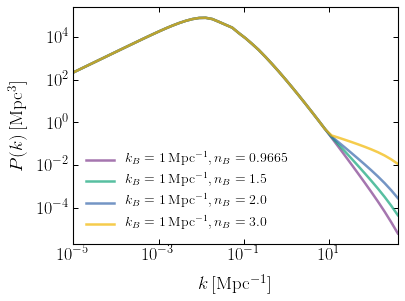

In [7]:
for i_n_B, CLASS_inst in enumerate(CLASS_inst_list):
    k_ary = np.logspace(-5, np.log10(400))
    pk_ary = np.array([CLASS_inst.pk_lin(k,0) for k in k_ary])
    plt.plot(k_ary, pk_ary, label="$k_B=1\,$Mpc$^{-1}, n_B=" + str(n_B_list[i_n_B]) + "$")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$k$\,[Mpc$^{-1}$]")
plt.ylabel("$P(k)$\,[Mpc$^{3}$]")
plt.xlim(min(k_ary), max(k_ary))
plt.legend(fontsize=14)

In [8]:
def dn_dM_s(M_sc, CLASS_inst):
    R = (M_sc / (4 / 3. * np.pi * rho_m)) ** (1 / 3.)
    sigma = CLASS_inst.sigma(R / Mpc, 0) 
    sigma_log_deriv = np.abs(M_sc * derivative(lambda M: np.log(CLASS_inst.sigma((M / (4 / 3. * np.pi * rho_m)) ** (1 / 3.) / Mpc, 0)), x0=M_sc, dx=0.8 * M_sc))
    return np.sqrt(2 / np.pi) * rho_m / M_sc ** 2 * delta_c / sigma * sigma_log_deriv * np.exp(-delta_c ** 2 / (2 * sigma ** 2))



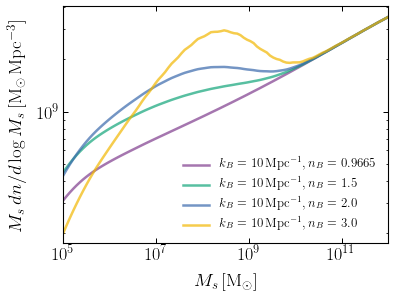

In [9]:
M_ary = np.logspace(5, 12, 100) * M_s

for i_n_B, CLASS_inst in enumerate(CLASS_inst_list):
    plt.plot(M_ary / M_s, [M ** 2 * dn_dM_s(M, CLASS_inst) / (Mpc ** -3) / M_s for M in M_ary], label="$k_B=10\,$Mpc$^{-1}, n_B=" + str(n_B_list[i_n_B]) + "$")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$M_s$\,[M$_\odot$]")
plt.ylabel("$M_s\, dn/d\log M_s\,[\mathrm{M_\odot}$\,Mpc$^{-3}$]")
plt.xlim(min(M_ary / M_s), max(M_ary / M_s))
plt.legend(fontsize=13)